In [16]:
import pandas as pd
import numpy as np
from twarc import Twarc
import constants as cnst
from newspaper import Article, ArticleException
from tqdm import tqdm
import string
import matplotlib.pylab as plt
import requests


In [17]:
# dataframe = pd.read_csv("./Organic_extended.csv", index_col=0) 
dataframe = pd.read_csv("./Organic_extended_final.csv", sep="|", index_col=0) 
print(len(dataframe))
dataframe[['screen_name','tweet_id']].groupby('screen_name').count()

31290


,tweet_id
screen_name,
ABC News,2711
CNN,2945
Fox News,223
HuffPost,967
Los Angeles Times,3485
NBC News,1899
NPR,1001
Reuters,7963
TIME,1630


In [18]:
dataframe['user_id'].unique()

array([16664681., 28785486.,   759251.,   807095.,  5392522.,  3108351.,
       51241574., 14173315., 15754281., 14293310.,  1652541., 14511951.,
        2467791.,  1367531.,  6577642.])

## Checking the NaNs
Checking for NaNs specifically in title, content, url and expanded_url

In [ ]:
condition = dataframe['expanded_url'].isnull()
print(len(dataframe), dataframe.loc[condition,['tweet_id']].count())

dataframe.loc[condition,['screen_name', 'tweet_id', 'title','content','expanded_url',['url']]]

In [20]:
dataframe = dataframe.dropna(subset=['title', 'content', 'url', 'expanded_url'])
print(len(dataframe))
dataframe[['screen_name','tweet_id']].groupby('screen_name').count()

29545


,tweet_id
screen_name,
ABC News,2529
CNN,2639
Fox News,222
HuffPost,960
Los Angeles Times,3286
NBC News,1878
NPR,983
Reuters,7778
TIME,1547


## Checking Non parent URLS

In [25]:
valid = "|".join(["abcnews.go.com/","www.cnn.com","www.huffpost.com", "latimes.com", "nbcnews.com",
                  "npr.org","reuters.com", "time.com","apnews.com","nytimes.com","wsj.com","usnews.com",
                  "usatoday.com", "foxnews.com","washingtonpost.com"])
condition = ~dataframe['expanded_url'].str.contains(valid, regex=True)
print(len(dataframe))
dataframe.loc[condition, ['screen_name','url', 'expanded_url']]

# dataframe.loc[condition, ['screen_name','expanded_url']].groupby('screen_name').count()

29545


,screen_name,url,expanded_url
12341,CNN,https://cnn.it/2YD9Jkl,https://edition.cnn.com/2020/06/14/world/nasa-...
12343,NPR,https://trib.al/iwPEB4K,https://www.wbur.org/hereandnow/2020/06/12/mer...
12344,NPR,https://trib.al/gcQSrOw,https://www.wbur.org/hereandnow/2020/06/12/kar...
12345,NPR,https://trib.al/U9Jpgp0,https://www.wbur.org/onlyagame/2020/06/12/hbcu...
12347,NPR,https://trib.al/TFcq7h2,https://www.wbur.org/hereandnow/2020/06/08/sar...
...,...,...,...
31157,Los Angeles Times,https://art19.com/shows/cant-stop-watching-tel...,https://art19.com/shows/cant-stop-watching-tel...
31241,NBC News,https://bit.ly/30HuFZQ,https://www.facebook.com/NBCNews/videos/204917...
31254,Fox News,https://fxn.ws/2Y5n7OO,https://www.foxbusiness.com/markets/us-stocks-...
31257,ABC News,https://abcn.ws/37uK7Kq,https://fivethirtyeight.com/features/how-to-re...


Removing non Parent

In [28]:
dataframe.loc[condition, 'expanded_url']= np.nan
dataframe = dataframe.dropna(subset=['expanded_url'])
print(len(dataframe))
dataframe.loc[condition, ['screen_name','url', 'expanded_url']]

dataframe[['screen_name','tweet_id']].groupby('screen_name').count()

29116


e:\project_viralnews\venv\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,tweet_id
screen_name,
ABC News,2449
CNN,2543
Fox News,221
HuffPost,960
Los Angeles Times,3269
NBC News,1805
NPR,929
Reuters,7763
TIME,1501


## Checking Title

mean    11.129173
amin     1.000000
amax    27.000000
Name: title_len, dtype: float64
Empty DataFrame
Columns: [tweet_id, title]
Index: []


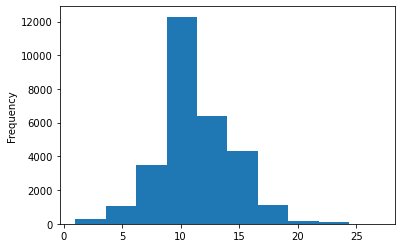

In [29]:
dataframe['title_len'] = dataframe['title'].str.split().str.len()
print(dataframe['title_len'].aggregate([np.mean, np.min, np.max]))
dataframe['title_len'].plot.hist(bins=10)
print(dataframe.loc[dataframe['title_len']==0, ['tweet_id','title']])
# length = dataframe['content'].str.len()
# length.min(), length.max(), length.mean()

## Checking content

mean      724.447177
amin        6.000000
amax    17822.000000
Name: content_len, dtype: float64


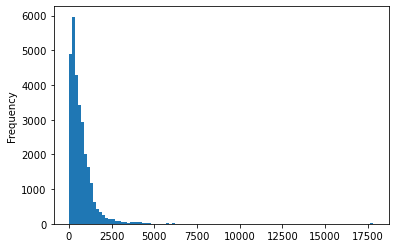

In [30]:
dataframe['content_len'] = dataframe['content'].str.split().str.len()
print(dataframe['content_len'].aggregate([np.mean, np.min, np.max]))
dataframe['content_len'].plot.hist(bins=100)

Removing by title

In [31]:
condition = dataframe['title_len'] < 3
dataframe.loc[condition,['screen_name','title','url', 'title_len','content_len']].head(30)
# dataframe.loc[condition,['screen_name','title']].groupby('screen_name').count()

,screen_name,title,url,title_len,content_len
3388,Reuters,India-China clash,https://reut.rs/3efViJx,2,1533
3807,Reuters,India-China clash,https://reut.rs/2Ch553H,2,1533
3866,Reuters,India-China clash,https://reut.rs/2Na1BlT,2,1533
3907,Reuters,India-China clash,https://reut.rs/3eswtKB,2,1533
4015,Reuters,India-China clash,https://reut.rs/2N7lUAu,2,1533
4136,Reuters,India-China clash,https://reut.rs/3emn6fq,2,1533
10246,The Wall Street Journal,MAGA—for All,https://on.wsj.com/2BjeFCX,2,86
12350,ABC News,ABC News,https://abcn.ws/2MYWmpe,2,29
12395,ABC News,ABC News,https://abcn.ws/2UOu5pD,2,29
12403,ABC News,ABC News,https://abcn.ws/37znLr9,2,29


Found legit title names like India-china clash for low title range. The one pointing to invalid content will be removed based on the content len. removing nothing based on title

Removing based on content len

In [33]:
condition = (dataframe['content_len'] <50)
dataframe.loc[condition, ['screen_name','url','title_len','content_len','content']].tail(30)
# dataframe.loc[condition, ['screen_name','tweet_id']].groupby('screen_name').count()

,screen_name,url,title_len,content_len,content
29937,ABC News,https://abcn.ws/3eMUAnd,2,29,External links are provided for reference purp...
29981,Reuters,https://reut.rs/2VxSsYR,6,33,"California, Florida, Arizona and Texas have em..."
30203,NBC News,https://nbcnews.to/2VBe2Mh,5,38,"In California and Arizona, increased coronavir..."
30209,ABC News,https://abcn.ws/2ZrJfCq,2,29,External links are provided for reference purp...
30235,Reuters,https://reut.rs/2VxSsYR,6,33,"California, Florida, Arizona and Texas have em..."
30301,ABC News,https://abcn.ws/2Vz0EIs,2,29,External links are provided for reference purp...
30303,Los Angeles Times,https://www.latimes.com/newsletters/the-wild,11,47,Newsletter Get The Wild newsletter.\n\nThe ess...
30355,ABC News,https://abcn.ws/3iosDEk,3,30,Highlighting the efforts of some of the countr...
30406,NBC News,https://nbcnews.to/2NKIvmv,10,45,"Lawayne Mosley, the father of Elijah McClain, ..."
30442,ABC News,https://abcn.ws/3g70qQN,2,29,External links are provided for reference purp...


Analysis reveals that these are either video posts, or homepage links, weather forecasts, link to embeded pfd, a post with embedded tweets, also includes some reuters post with one para data.

In [34]:
dataframe.loc[condition, 'content'] = np.nan
dataframe = dataframe.dropna()
print(len(dataframe))
dataframe[['screen_name','6']].groupby('screen_name')['6'].count()

28471


screen_name
ABC News                   2203
CNN                        2499
Fox News                    221
HuffPost                    948
Los Angeles Times          3231
NBC News                   1682
NPR                         929
Reuters                    7700
TIME                       1499
The Associated Press        715
The New York Times         1680
The Wall Street Journal    1869
The Washington Post        1993
U.S. News                     3
USA TODAY                  1299
Name: 6, dtype: int64

In [35]:
dataframe.to_csv("./Organic_extended_finalv3.csv", sep="|") 

mean    11.236381
amin     1.000000
amax    27.000000
Name: title_len, dtype: float64
Empty DataFrame
Columns: [tweet_id, title]
Index: []


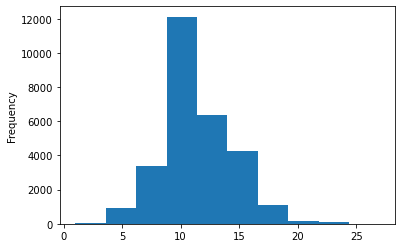

In [36]:
dataframe['title_len'] = dataframe['title'].str.split().str.len()
print(dataframe['title_len'].aggregate([np.mean, np.min, np.max]))
dataframe['title_len'].plot.hist(bins=10)
print(dataframe.loc[dataframe['title_len']==0, ['tweet_id','title']])

mean      740.156651
amin       50.000000
amax    17822.000000
Name: content_len, dtype: float64


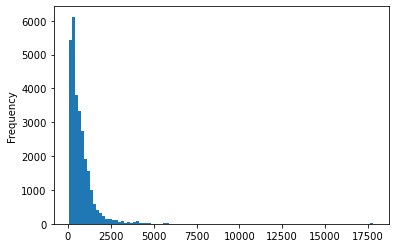

In [37]:
dataframe['content_len'] = dataframe['content'].str.split().str.len()
print(dataframe['content_len'].aggregate([np.mean, np.min, np.max]))
dataframe['content_len'].plot.hist(bins=100)

In [38]:
len(dataframe)

28471

In [57]:
dataframe = dataframe.dropna()
len(dataframe)

28471